In [82]:
import json
import os
import pickle
import psycopg2
import sqlalchemy
import pyproj
import sys
sys.path.append("..")

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
from shapely.geometry import Point
get_ipython().magic(u'matplotlib inline')
%matplotlib inline

from connect_db import db_connection

# filter annyoing warning from pandas
import warnings
warnings.filterwarnings('ignore')

In [83]:
username='kmohan'

In [84]:
cred_location = '/mnt/data/'+username+'/TPT_tourism/connect_db/data_creds_redshift.json.nogit'
db = db_connection.DBConnection(cred_location)

In [94]:
# run the query for the vodafone data (takes some time)
# TODO: In the future, this query will alread calculate the counts for the heatmap

query = """
with loc_times as (
	select tuscany.vodafone.customer_id,  vodafone.location_id, loc.region, time_stamp, lag(time_stamp,1) 
	over (partition by customer_id order by time_stamp asc) as t2
	from tuscany.vodafone
    inner join tuscany.location_dictionary loc on loc.location_id = vodafone.location_id
    order by time_stamp asc  
),


tusc_loc_times as (select customer_id,loc_times.location_id, region,sum(datediff(minutes,t2,time_stamp)) as mins_at_loc
from loc_times
where t2 is not null and region = 9
group by customer_id,location_id,region
)

select customer_id,max(mins_at_loc) from tusc_loc_times
group by customer_id;

"""
df_customer_feature = db.sql_query_to_data_frame(query)

InternalError: (psycopg2.InternalError) Disk Full
DETAIL:  
  -----------------------------------------------
  error:  Disk Full
  code:      1016
  context:   node: 0
  query:     10954
  location:  fdisk_api.cpp:493
  process:   query0_119_10954 [pid=11252]
  -----------------------------------------------

 [SQL: '\nwith loc_times as (\n\tselect tuscany.vodafone.customer_id,  vodafone.location_id, loc.region, time_stamp, lag(time_stamp,1) \n\tover (partition by customer_id order by time_stamp asc) as t2\n\tfrom tuscany.vodafone\n    inner join tuscany.location_dictionary loc on loc.location_id = vodafone.location_id\n    order by time_stamp asc  \n),\n\n\ntusc_loc_times as (select customer_id,loc_times.location_id, region,sum(datediff(minutes,t2,time_stamp)) as mins_at_loc\nfrom loc_times\nwhere t2 is not null and region = 9\ngroup by customer_id,location_id,region\n)\n\nselect customer_id,max(mins_at_loc) from tusc_loc_times\ngroup by customer_id;\n\n'] (Background on this error at: http://sqlalche.me/e/2j85)

In [96]:
df_customer_feature['max'] = df_customer_feature['max']*60
len(df_customer_feature[df_customer_feature['max']<=1])

1423465

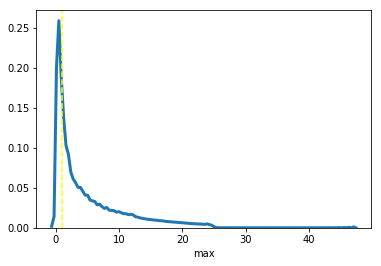

In [98]:
sns.distplot(df_customer_feature['max'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3})
plt.axvline(1, linestyle='--', color="yellow", label='1 hour')

In [97]:
df_customer_feature['max']

0           1.816667
1           0.650000
2           1.333333
3           7.550000
4           1.550000
5           0.650000
6           0.050000
7           2.900000
8           1.966667
9           0.116667
10          1.200000
11          3.550000
12          4.300000
13          1.500000
14          0.166667
15          0.516667
16          1.383333
17          3.750000
18         17.950000
19          1.750000
20          0.633333
21         10.033333
22          8.066667
23          9.983333
24          0.733333
25         12.016667
26          1.150000
27          2.566667
28         13.900000
29          6.150000
             ...    
3167104     8.766667
3167105     5.983333
3167106     5.200000
3167107     0.166667
3167108     0.016667
3167109     0.016667
3167110     3.750000
3167111    13.433333
3167112     3.083333
3167113     0.700000
3167114     0.000000
3167115     0.000000
3167116     6.783333
3167117     0.000000
3167118    10.816667
3167119    23.816667
3167120     0

In [90]:
ratio_of_people=[]
for i in range(0,25):
    ratio_of_people.append(len(df_customer_feature[df_customer_feature['max']<i])/len(df_customer_feature))

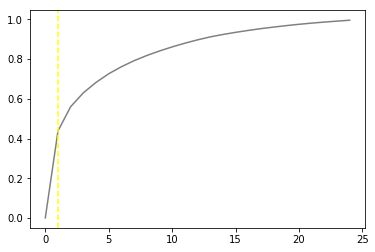

In [92]:
plt.plot(range(0,25),ratio_of_people[:25], color="grey")
plt.axvline(1, linestyle='--', color="yellow", label='1 hour')

In [74]:
len(ratio_of_people)

48

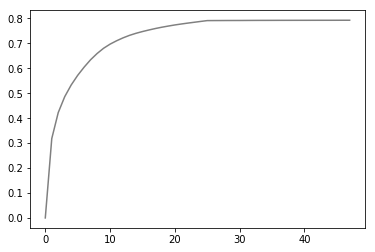

In [76]:
plt.plot(range(0,48),ratio_of_people[:48], color="grey")

In [43]:
ratio_of_people2=[]
for i in range(0,5*40):
    ratio_of_people2.append(len(df_customer_feature[df_customer_feature['locs_per_hr']<i])/len(df_customer_feature))

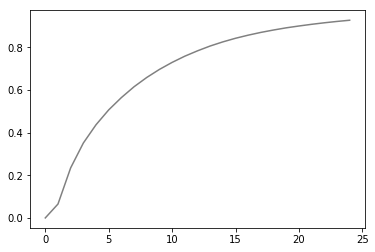

In [44]:
plt.plot(range(0,25),ratio_of_people2[:25], color="grey")

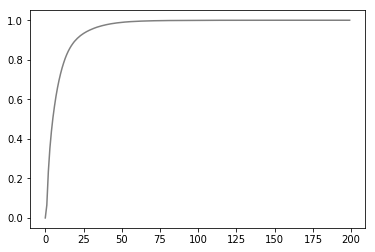

In [45]:
plt.plot(range(0,200),ratio_of_people2[:200], color="grey")